# Vodafone Music Challenge

---
## Project description
The goal of the project is to build a machine learning model to predict the probability that a mobile operator subscriber will install and pay for the Vodafone Music service within one month after the scoring date.

Task type: **binary classification**

Target variable:

* `1` — installed and paid for
* `0` — did not install

The model should predict not just the class, but the probability of installing the service, allowing the business to flexibly choose the customer selection threshold for the campaign.

Evaluation metric: **ROC-AUC**

---

## Data

The data contains information about subscribers and their behavior.

Main groups of characteristics:

- `Device characteristics` — device characteristics
- `General characteristics` — general characteristics of the subscriber
- `User activity features` — user activity
- `All costs` — monthly costs
- `Recharge statistics` — recharge statistics
- `Voice costs & duration` — voice costs and call duration
- `Network action stats` — network events
- `Other Essential Features` — use of other services (including data traffic)
- `SMS from Services` — number of incoming SMS messages from various services  
- `Interests data` — interests and use of services
- `Previous campaigns results` — participation in previous campaigns

Aggregates are calculated for:
- `m1` — previous month
- `m2` — second previous month
- `m3` — third month


## 1. Import the necessary libraries

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 2. Data upload

In [56]:
bucket = "tkachenko-ml-dataset"
music_df = pd.read_csv(f"s3://{bucket}/train_music.csv")
music_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 461 columns):
 #    Column                               Non-Null Count  Dtype  
---   ------                               --------------  -----  
 0    id                                   70000 non-null  int64  
 1    target                               70000 non-null  int64  
 2    device_type                          70000 non-null  int64  
 3    manufacturer_category                70000 non-null  int64  
 4    os_category                          70000 non-null  int64  
 5    sim_count                            69301 non-null  float64
 6    tp_flag                              70000 non-null  int64  
 7    lt                                   70000 non-null  float64
 8    block_flag                           70000 non-null  int64  
 9    days_exp                             69993 non-null  float64
 10   service_1_flag                       69993 non-null  float64
 11   service_1_cou

**All features are numerical (float64 and int64). There are no categorical variables. The dataset is completely ready for use in ML models without additional coding. It contains many missing values.**

## 3. Pre-treatment

In [57]:
# Dataset dimension
print("Shape:", music_df.shape)
print("Rows:", music_df.shape[0])
print("Columns:", music_df.shape[1])

Shape: (70000, 461)
Rows: 70000
Columns: 461


**The dataset contains 70,000 observations and 461 features.
The amount of data is sufficient to build a stable model.**

In [58]:
# Proportion of absences
missing = music_df.isnull().mean().sort_values(ascending=False)

# Select features with more than 95% missing values
high_missing = (
    missing[missing > 0.95]
    .sort_values()
    .reset_index()
)

# Rename columns for clarity
high_missing.columns = ['feature', 'missing_ratio']

# Display missing values
missing.head(20)

count_url_category_13    0.992771
count_url_category_15    0.987029
count_app_3              0.986643
vol_app_3                0.986643
count_url_category_12    0.983129
vol_app_11               0.977329
count_app_11             0.977329
count_app_13             0.973143
vol_app_13               0.973143
count_url_category_1     0.972186
count_gift_type_4        0.969586
rr_gift_type_4           0.969586
count_app_16             0.967171
vol_app_16               0.967171
count_app_14             0.964086
vol_app_14               0.964086
count_url_category_11    0.948486
service_9_flag_m3        0.947871
service_9_flag_m1        0.945414
service_9_flag_m2        0.945157
dtype: float64

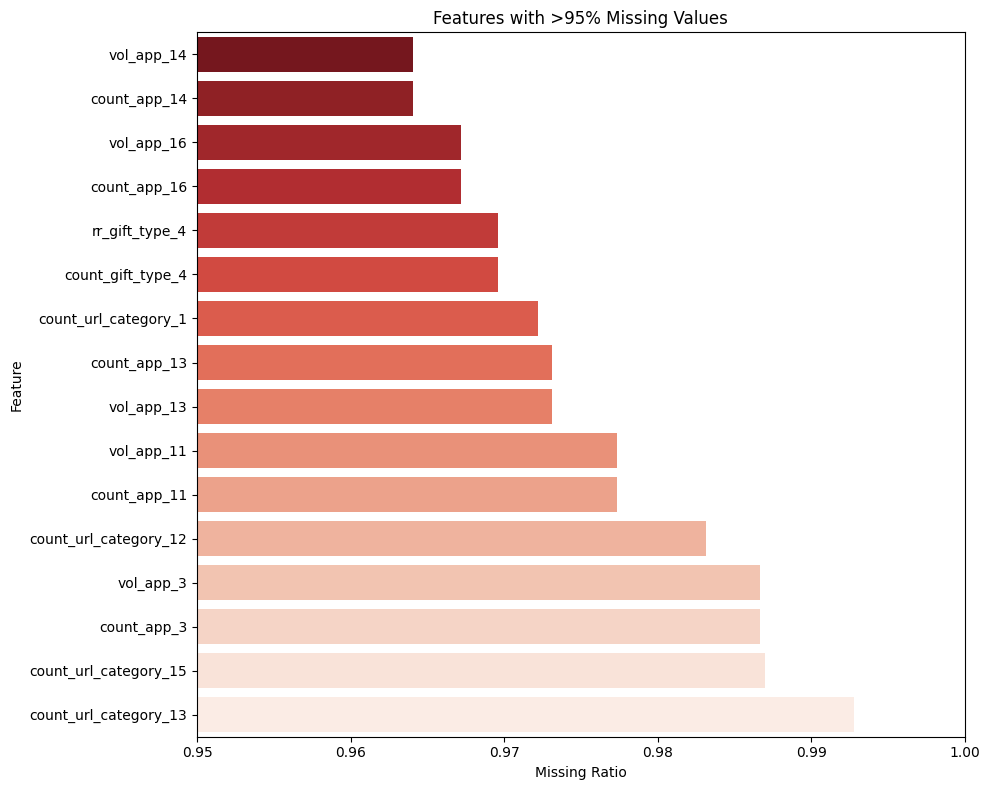

In [59]:
plt.figure(figsize=(10, 8))

sns.barplot(
    data=high_missing,
    y='feature',
    x='missing_ratio',
    hue='feature',
    palette='Reds_r',
    legend=False
)

plt.xlim(0.95, 1.0)
plt.xlabel("Missing Ratio")
plt.ylabel("Feature")
plt.title("Features with >95% Missing Values")

plt.tight_layout()
plt.show()

In [60]:
# All missing entries in the csv file
missing_counts = music_df.isnull().sum()
missing_counts[missing_counts > 0].to_csv("missing_columns.csv")

**An analysis of missing values showed that a significant proportion of features contain high levels of missing values, with some variables having over 90% NaN.**

In [61]:
# Target Distribution
target_counts = music_df['target'].value_counts()
target_percentage = music_df['target'].value_counts(normalize=True)
print(target_counts)
print(target_percentage)

target
0    64699
1     5301
Name: count, dtype: int64
target
0    0.924271
1    0.075729
Name: proportion, dtype: float64


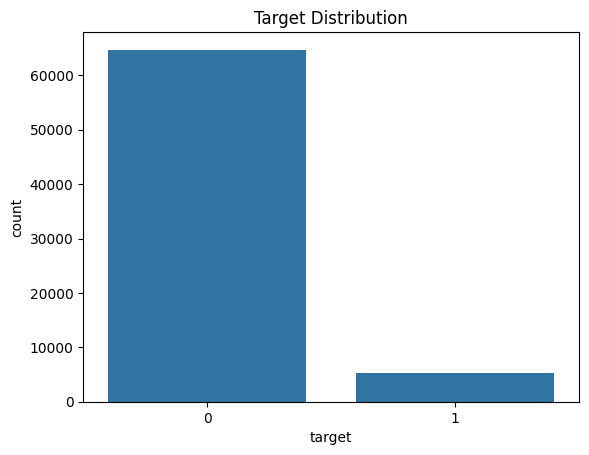

In [62]:
sns.countplot(x='target', data=music_df)
plt.title("Target Distribution")
plt.show()

**The positive class accounts for `7.57%`, while the negative class accounts for `92.43%`.**

**The dataset is significantly unbalanced, which must be taken into account when training the model.**

In [63]:
# Keywords that may indicate leakage
suspicious_keywords = [
    'music', 'install', 
    'payment', 'future', 
    'next', 'subscription'
]

# Searching columns
leakage_cols = [
    col for col in music_df.columns
    if any(word in col.lower() for word in suspicious_keywords)
]

leakage_cols


[]

In [64]:
corr_with_target = music_df.corr()['target'].sort_values(ascending=False)

# Top 10 most correlated features
corr_with_target.head(10)

target               1.000000
id                   0.154761
content_count_m1     0.116450
vol_app_11           0.112219
content_count_m3     0.111245
count_app_11         0.103440
content_count_m2     0.094392
count_gift_type_3    0.081626
count_app_5          0.076582
count_act_type_6     0.073582
Name: target, dtype: float64

In [65]:
# Checking the correlation between id and target
music_df[['id', 'target']].corr()


,id,target
id,1.000000,0.154761
target,0.154761,1.000000


**No suspicious columns containing information about future events or directly related to the installation of the service were found.
Correlation analysis did not reveal any signs of correlation close to 1, which would indicate a direct information leak.
The `id` column should be excluded from the feature set before training the model, as it is a technical identifier.**

## 4. Data Cleaning

In [66]:
# Calculate the proportion of missing values and exclude features with more than 95% missing values.
missing_ratio = music_df.isnull().mean()

high_missing_thresh = 0.95
high_missing_cols = missing_ratio[missing_ratio > high_missing_thresh].index.tolist()

print("Columns with >95% missing:", len(high_missing_cols))
high_missing_cols[:20]


Columns with >95% missing: 16


['count_url_category_1',
 'count_url_category_12',
 'count_url_category_13',
 'count_url_category_15',
 'vol_app_3',
 'vol_app_11',
 'vol_app_13',
 'vol_app_14',
 'vol_app_16',
 'count_app_3',
 'count_app_11',
 'count_app_13',
 'count_app_14',
 'count_app_16',
 'rr_gift_type_4',
 'count_gift_type_4']

In [67]:
# Delete features with more then 95% missing data
music_df = music_df.drop(columns=high_missing_cols)
print("Shape after dropping high-missing cols:", music_df.shape)


Shape after dropping high-missing cols: (70000, 445)


**16 features with a miss rate of over 95% were identified. These features contain insufficient information for effective model training and were therefore removed.**

In [68]:
# Fill in the remaining gaps with zeros
music_df = music_df.fillna(0)
music_df.isnull().sum().sum()

0

In [69]:
# Сheck for infinity
num_cols = music_df.columns.drop(['target'], errors='ignore')

inf_mask = np.isinf(music_df[num_cols]).any()
print("Any inf:", inf_mask)

# if there is inf — replace with NaN and then with 0
music_df[num_cols] = music_df[num_cols].replace([np.inf, -np.inf], np.nan)
music_df[num_cols] = music_df[num_cols].fillna(0)


Any inf: id                       False
device_type              False
manufacturer_category    False
os_category              False
sim_count                False
                         ...  
income_brnd_cont_m3      False
data_type_1_m3           False
data_type_2_m3           False
data_type_3_m3           False
service_9_flag_m3        False
Length: 444, dtype: bool


**The analysis showed that the dataset does not contain values of type `inf` or `-inf`. 
No additional cleaning of this type of anomaly is required.**

In [70]:
# Presence of negative values
neg_counts = (music_df[num_cols] < 0).sum().sort_values(ascending=False)
neg_counts = neg_counts[neg_counts > 0]
neg_counts.head(20)


balance_sum            1211
pay_out_P2P_cost_m2     971
pay_out_P2P_cost_m1     960
pay_out_P2P_cost_m3     898
days_exp                535
paym_el_sum_m3            4
paym_sum_m3               4
paym_sum_m2               2
paym_el_sum_m2            2
paym_el_sum_m1            2
paym_sum_m1               2
dtype: int64

In [71]:
# Replace all negative values with 0
music_df[num_cols] = music_df[num_cols].clip(lower=0)


**11 features with negative values were detected. Such features are incorrect, so they were replaced with 0.**

In [72]:
# Constant attributes (only 1 unique value)
constant_cols = [c for c in music_df.columns if c not in ['target', 'id'] and music_df[c].nunique() <= 1]
print("Constant columns:", len(constant_cols))
constant_cols[:20]


Constant columns: 17


['rr_act_type_7',
 'rr_gift_type_1',
 'pay_out_P2P_cost_m1',
 'voice_omo_in_cost_m1',
 'voice_pstn_in_cost_m1',
 'sms_roam_in_count_m1',
 'service_8_count_m1',
 'pay_out_P2P_cost_m2',
 'voice_omo_in_cost_m2',
 'voice_pstn_in_cost_m2',
 'sms_roam_in_count_m2',
 'service_8_count_m2',
 'pay_out_P2P_cost_m3',
 'voice_omo_in_cost_m3',
 'voice_pstn_in_cost_m3',
 'sms_roam_in_count_m3',
 'service_8_count_m3']

In [73]:
music_df = music_df.drop(columns=constant_cols)
print("Shape after dropping constant cols:", music_df.shape)


Shape after dropping constant cols: (70000, 428)


**Seventeen constant features were identified that had only one unique value in the entire dataset. Such variables contain no information and cannot influence the model, so they were removed. After cleaning, the number of features decreased to 428.**

In [74]:
# Almost constant (one value occupies, for example, ≥ 99.5%)
near_const_thresh = 0.995  # 99.5%

near_constant_cols = []
# Iterate through all columns
for c in music_df.columns:
    # Exclude target and id from filtering
    if c in ['target', 'id']:
        continue
    # Calculate frequency of the most common value
    top_freq = music_df[c].value_counts(normalize=True, dropna=False).iloc[0]
    # If the dominant value exceeds the threshold → mark as near-constant
    if top_freq >= near_const_thresh:
        near_constant_cols.append(c)

print("Near-constant columns:", len(near_constant_cols))
near_constant_cols[:20]


Near-constant columns: 47


['service_2_flag',
 'inact_days_count',
 'count_sms_source_1',
 'count_sms_source_2',
 'sms_roam_cost_m1',
 'voice_pstn_out_cost_m1',
 'voice_roam_out_cost_m1',
 'voice_onnet_cc_dur_m1',
 'voice_omo_cc_dur_m1',
 'voice_pstn_out_dur_m1',
 'voice_pstn_out_count_m1',
 'voice_onnet_cc_count_m1',
 'voice_omo_cc_count_m1',
 'sms_onnet_out_pack_count_m1',
 'sms_omo_out_pack_count_m1',
 'sms_roam_out_count_m1',
 'service_5_count_m1',
 'sms_roam_cost_m2',
 'voice_pstn_out_cost_m2',
 'voice_roam_out_cost_m2']

In [75]:
music_df = music_df.drop(columns=near_constant_cols, errors='ignore')
print("Shape after dropping near-constant cols:", music_df.shape)

Shape after dropping near-constant cols: (70000, 381)


**Forty-seven nearly constant features were identified, in which one value dominates in more than 99% of observations. Such variables have low informativeness and were removed. After cleaning, the number of features was reduced to 381.**

In [76]:
# We do not use id as a feature
X = music_df.drop(columns=['target', 'id'], errors='ignore')
y = music_df['target'].copy()
print(X.shape, y.shape)

(70000, 379) (70000,)


**The `id` column has been excluded as a technical identifier with no informational value.**

In [77]:
music_df.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 381 columns):
 #    Column                               Non-Null Count  Dtype  
---   ------                               --------------  -----  
 0    id                                   70000 non-null  int64  
 1    target                               70000 non-null  int64  
 2    device_type                          70000 non-null  int64  
 3    manufacturer_category                70000 non-null  int64  
 4    os_category                          70000 non-null  int64  
 5    sim_count                            70000 non-null  float64
 6    tp_flag                              70000 non-null  int64  
 7    lt                                   70000 non-null  float64
 8    block_flag                           70000 non-null  int64  
 9    days_exp                             70000 non-null  float64
 10   service_1_flag                       70000 non-null  float64
 11   service_1_cou

**As a result, we have a cleaned dataset without noise features and without gaps, ready for further processing and training.**

## 5. Advanced EDA

In [78]:
# Combine features (X) and target (y) into one DataFrame for EDA
df_eda = pd.concat([X, y.rename("target")], axis=1)

# Quick check
print("EDA shape:", df_eda.shape)
print("Target distribution:\n", df_eda["target"].value_counts(normalize=True))

EDA shape: (70000, 380)
Target distribution:
 target
0    0.924271
1    0.075729
Name: proportion, dtype: float64


In [79]:
# 1) Grouped statistics: mean and std for each feature by target class
group_stats = df_eda.groupby("target").agg(["mean", "std"])

# Transpose for easier reading (features as rows)
group_stats_T = group_stats.T

# Show a small preview
display(group_stats_T.head(20))

target                               0           1
device_type           mean    6.526082    6.612715
                      std     1.205498    1.149889
manufacturer_category mean  887.583301  889.811356
                      std   493.479463  454.224745
os_category           mean    7.800723    6.388417
                      std     9.620558    8.396959
sim_count             mean    1.590674    1.576495
                      std     0.512794    0.516562
tp_flag               mean    0.085164    0.045840
                      std     0.279127    0.209159
lt                    mean    0.797040    0.686682
                      std     0.153675    0.156491
block_flag            mean    0.027558    0.010941
                      std     0.163705    0.104037
days_exp              mean  318.267129  320.209772
                      std   102.181232   81.204230
service_1_flag        mean    0.419914    0.354084
                      std     0.493548    0.478280
service_1_count       mean  251.133325  174.822675
                      std   441.877686  383.027668

**The comparison of mean values between target classes reveals several behavioral differences.**

Users who installed Vodafone Music (target=1) tend to:
- have lower life time(lt), 
- have fewer service-related flags,
- have fewer account blocks.

**Device-related features show minimal difference between classes, indicating weak standalone predictive power.**

In [80]:
# 2) Mean difference: (mean in class 1) - (mean in class 0)
mean_by_class = df_eda.groupby("target").mean(numeric_only=True)

mean_diff = (mean_by_class.loc[1] - mean_by_class.loc[0]).sort_values(ascending=False)

# Show top positive and top negative differences
top_pos = mean_diff.head(20)
top_neg = mean_diff.tail(20)

print("Top features higher for target=1:")
display(top_pos)

print("\nTop features lower for target=1:")
display(top_neg)

Top features higher for target=1:


vol_app_5                          6.003315e+08
vol_app_1                          1.723384e+07
vol_app_15                         2.065451e+06
data_type_2_m1                     1.281145e+03
data_type_2_m2                     8.880869e+02
count_app_5                        7.213376e+02
data_type_2_m3                     6.378993e+02
count_app_1                        3.346651e+02
voice_omo_out_dur_m1               2.676872e+02
data_type_3_m1                     1.949561e+02
voice_omo_out_dur_m2               1.923148e+02
data_type_1_m1                     1.563887e+02
voice_omo_out_dur_m3               1.341843e+02
count_app_7                        1.314171e+02
paym_last_days                     1.157620e+02
data_type_1_m2                     9.307093e+01
voice_omo_out_day_work_dur_m1      9.107006e+01
data_type_3_m2                     8.892895e+01
voice_omo_out_night_work_dur_m1    7.249545e+01
data_type_1_m3                     7.065316e+01
dtype: float64


Top features lower for target=1:


voice_all_out_dur_m1              -2.552144e+03
voice_onnet_out_day_work_dur_m3   -2.687489e+03
voice_all_in_dur_m3               -2.822719e+03
voice_onnet_in_dur_m3             -2.828275e+03
voice_onnet_out_dur_m1            -2.846100e+03
vol_app_12                        -2.863673e+03
voice_all_out_dur_m2              -3.204600e+03
voice_onnet_out_dur_m2            -3.415288e+03
voice_all_out_dur_m3              -3.797248e+03
voice_onnet_out_dur_m3            -3.950331e+03
block_all_dur_m1                  -6.756021e+03
vol_app_2                         -8.146538e+03
block_all_dur_m3                  -8.529351e+03
block_all_dur_m2                  -1.224062e+04
vol_app_8                         -9.655892e+04
vol_app_10                        -1.099759e+05
vol_app_9                         -2.264985e+05
vol_app_6                         -1.836803e+06
vol_app_4                         -2.283699e+06
vol_app_7                         -2.896798e+07
dtype: float64

**Users who installed Vodafone Music (target=1) demonstrate significantly higher mobile data and app usage compared to non-users. In contrast, they show lower traditional voice activity (on-net and overall call duration) and fewer account block events. This indicates that Vodafone Music adoption is strongly associated with digitally active users rather than voice-oriented subscribers.**

service_9_flag_m1      0.135877
service_9_flag_m2      0.116279
content_count_m1       0.108292
service_9_flag_m3      0.096357
content_count_m3       0.086058
count_act_type_3       0.079204
content_count_m2       0.078608
count_app_5            0.074512
data_type_2_m1         0.058852
vol_app_5              0.056170
paym_count_m1          0.054097
all_cost_m1            0.052700
paym_el_count_m1       0.052631
data_type_3_m1         0.050772
rr_act_type_3          0.050428
income_brnd_cont_m1    0.048295
count_gift_type_3      0.048115
rr_gift_type_3         0.047445
rr_act_type_8          0.047397
sms_in_count_m1        0.045369
Name: target, dtype: float64

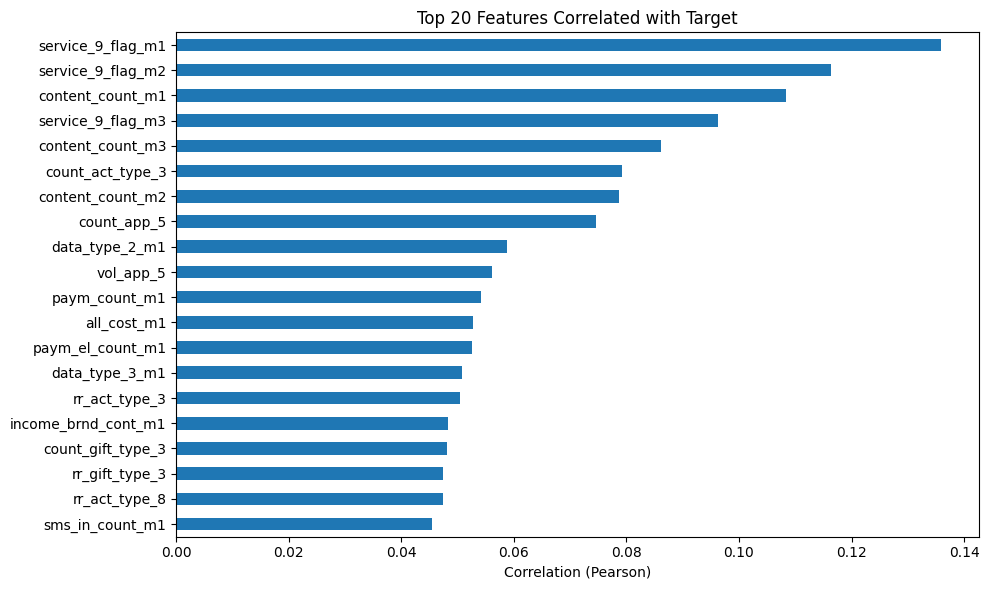

In [81]:
# 3) Correlation with target (Pearson)
corr_with_target = (
    df_eda.corr(numeric_only=True)["target"]
    .drop("target")
    .sort_values(ascending=False)
)

# Print top 20 correlated features
display(corr_with_target.head(20))

# Plot top 20 correlations
plt.figure(figsize=(10, 6))
corr_with_target.head(20).sort_values().plot(kind="barh")
plt.title("Top 20 Features Correlated with Target")
plt.xlabel("Correlation (Pearson)")
plt.tight_layout()
plt.show()

**The strongest correlations with the target are moderate (max ≈ 0.13), indicating no single dominant predictor.**

Top correlated features are related to:
- service subscription flags,
- content usage,
- app activity,
- payment behavior.

**This suggests that Vodafone Music adoption is primarily associated with digitally active and service-engaged users rather than a single behavioral factor.**

,feature,mutual_info
5,lt,0.023006
80,service_P_flag_m1,0.012104
181,service_P_flag_m2,0.011614
280,service_P_flag_m3,0.010830
0,device_type,0.010384
172,content_count_m1,0.009639
369,content_count_m3,0.009370
13,balance_sum,0.008568
176,income_brnd_cont_m1,0.008514
188,content_cost_m2,0.008152


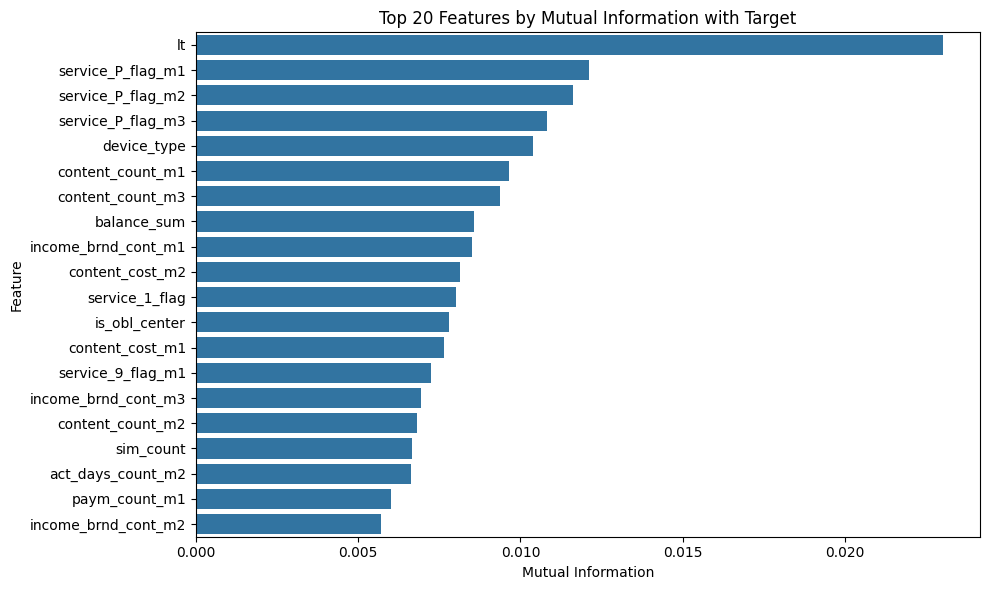

In [82]:
# 4) Mutual Information: captures non-linear dependency between feature and target
mi = mutual_info_classif(X, y, random_state=42)

mi_df = (
    pd.DataFrame({"feature": X.columns, "mutual_info": mi})
    .sort_values("mutual_info", ascending=False)
)

# Show top 20 MI features
display(mi_df.head(20))

# Plot top 20 MI features
plt.figure(figsize=(10, 6))
sns.barplot(data=mi_df.head(20), y="feature", x="mutual_info")
plt.title("Top 20 Features by Mutual Information with Target")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**Mutual Information highlights `lt` (Life Time of Client) as the strongest predictor. Users with lower lifetime values (newer clients) are more likely to install Vodafone Music. Service-related flags and content usage features also show clear distribution shifts between classes. However, strong overlap between distributions suggests that no single feature can separate the classes alone — predictive power is distributed across multiple behavioral signals.**

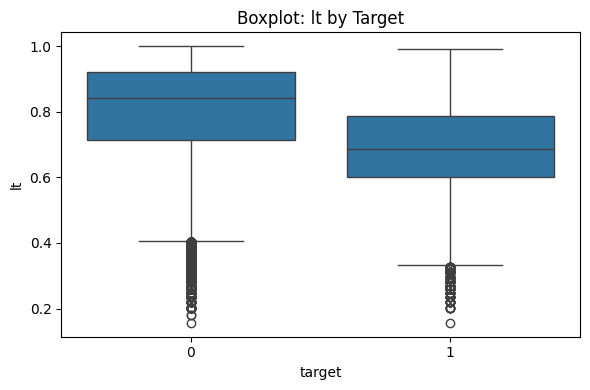

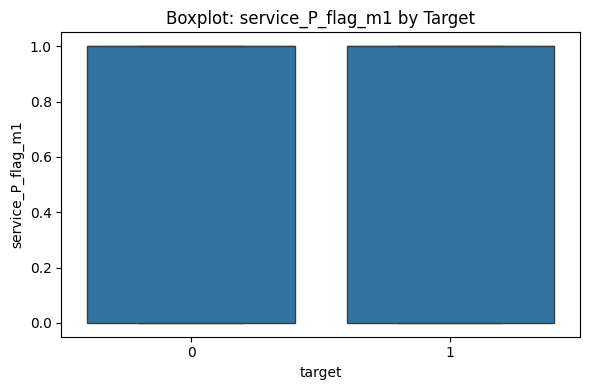

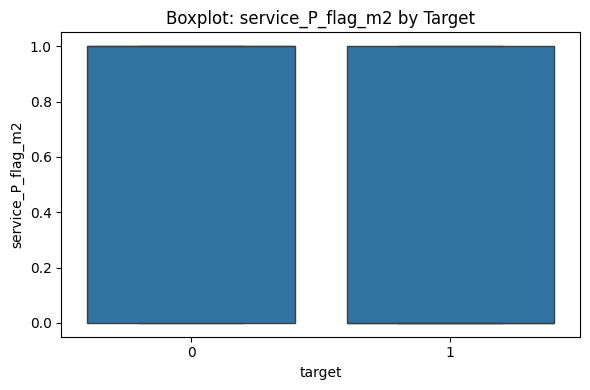

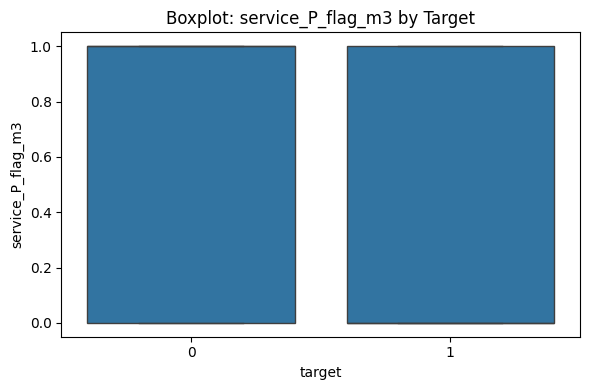

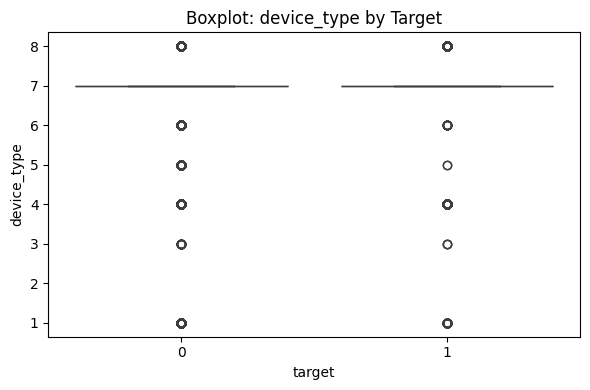

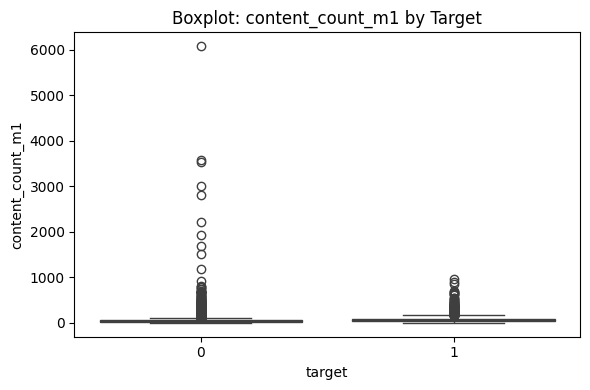

In [83]:
# 5) Boxplots: compare feature distributions across target classes
top_features = mi_df.head(6)["feature"].tolist()  # choose 6 to keep plots readable

for col in top_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_eda, x="target", y=col)
    plt.title(f"Boxplot: {col} by Target")
    plt.tight_layout()
    plt.show()


**The clearest separation is observed for `lt` (Life Time of Client): users with lower lifetime values are more likely to install Vodafone Music.**

**Service-related flags also show differences in distribution between classes, indicating behavioral engagement effects.**

**Content usage features demonstrate slightly higher activity for target=1 users, but distributions strongly overlap, meaning no single feature can independently separate the classes.**

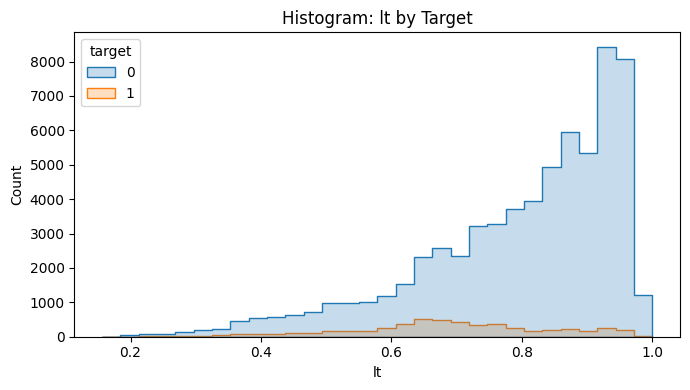

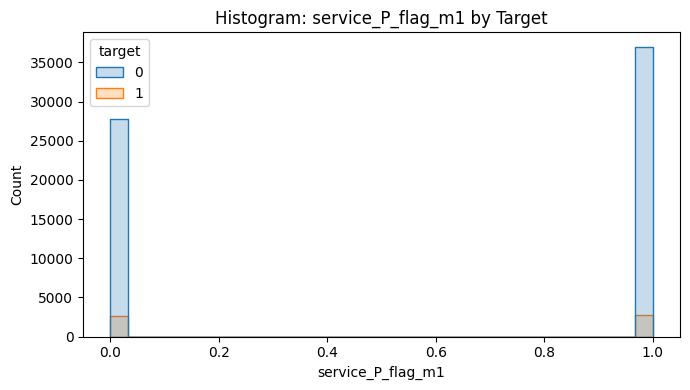

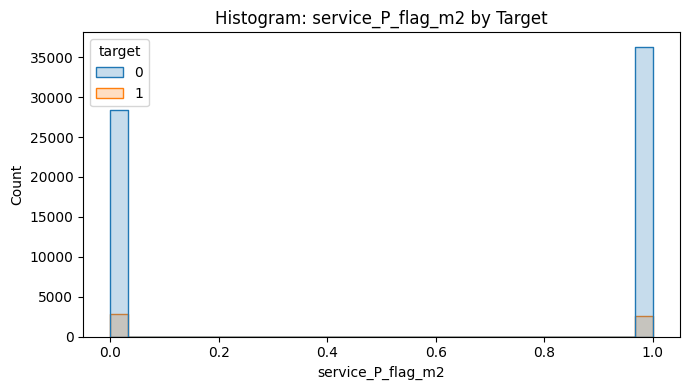

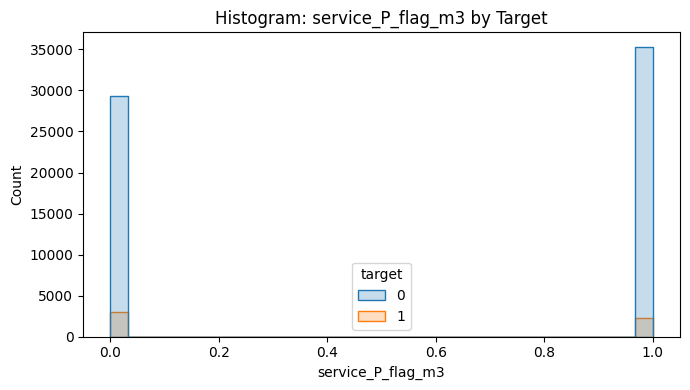

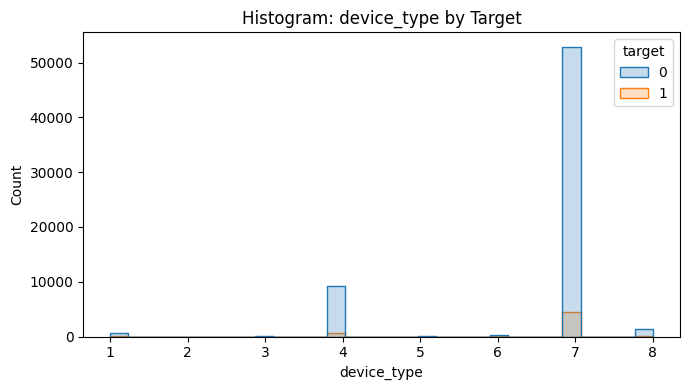

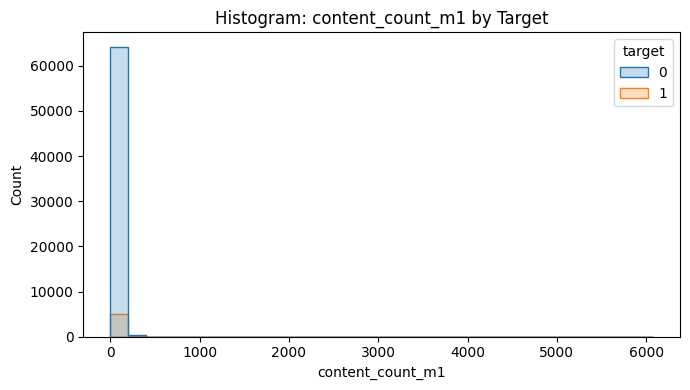

In [84]:
# 6) Histograms: compare distribution shape across classes (target=0 vs target=1)
for col in top_features:
    plt.figure(figsize=(7, 4))
    sns.histplot(data=df_eda, x=col, hue="target", bins=30, element="step", kde=False)
    plt.title(f"Histogram: {col} by Target")
    plt.tight_layout()
    plt.show()

**The strongest distribution shift is observed for `lt` (Life Time of Client). Service-related flags also show different class proportions, indicating behavioral engagement effects. Content activity features demonstrate slightly higher activity for target=1 users, but distributions strongly overlap.**

**Overall, no single feature perfectly separates the classes; predictive power is distributed across multiple behavioral patterns.**

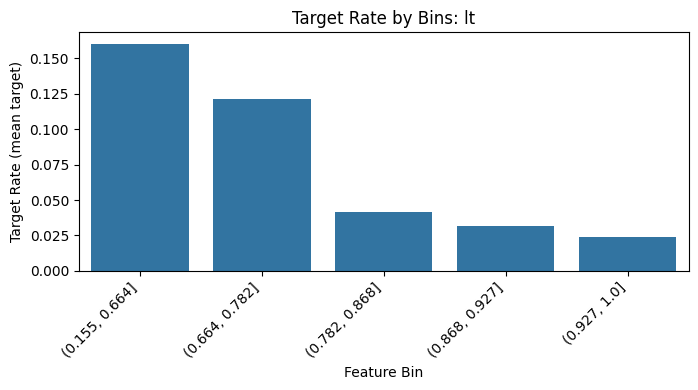

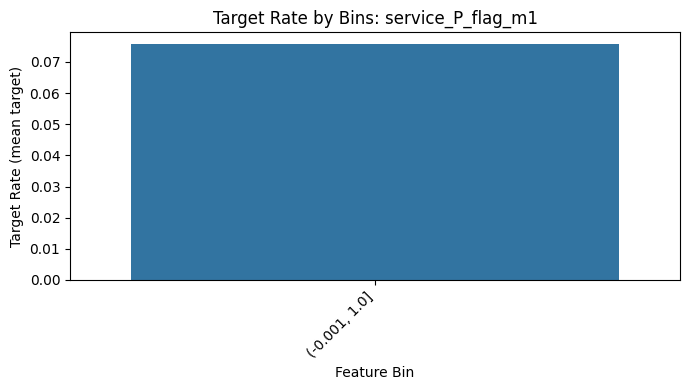

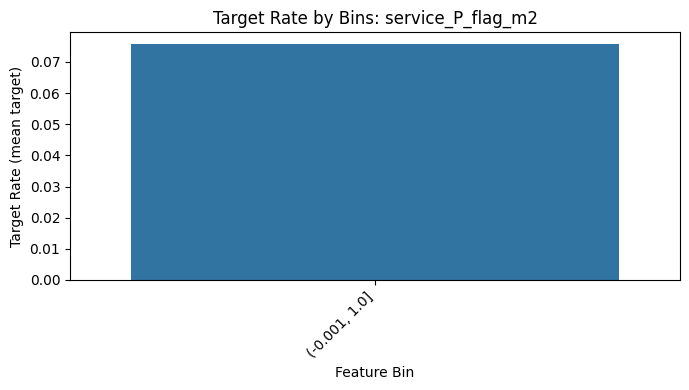

In [85]:
# 7) Target rate by quantile bins: shows adoption rate across feature levels
def target_rate_by_bins(df, feature, n_bins=5):
    """
    Split a feature into quantile bins and compute mean(target) per bin.
    mean(target) = target rate (share of class 1).
    """
    tmp = df[[feature, "target"]].copy()
    
    # Use qcut for equal-sized groups; fallback to cut if not enough unique values
    try:
        tmp["bin"] = pd.qcut(tmp[feature], q=n_bins, duplicates="drop")
    except ValueError:
        tmp["bin"] = pd.cut(tmp[feature], bins=n_bins)
    
    rates = tmp.groupby("bin", observed=False)["target"].mean().reset_index()
    return rates

# Pick 3 strongest MI features (often good candidates)
features_for_bins = mi_df.head(3)["feature"].tolist()

for col in features_for_bins:
    rates = target_rate_by_bins(df_eda, col, n_bins=5)

    plt.figure(figsize=(7, 4))
    sns.barplot(data=rates, x="bin", y="target")
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Target Rate by Bins: {col}")
    plt.ylabel("Target Rate (mean target)")
    plt.xlabel("Feature Bin")
    plt.tight_layout()
    plt.show()


**Clients with lower lifetime values show significantly higher adoption rates (16%), while long-term clients exhibit much lower adoption (2–3%). This confirms that Vodafone Music is primarily adopted by newer subscribers. For binary service flags, binning is less informative, but earlier analysis confirms their association with the target.**

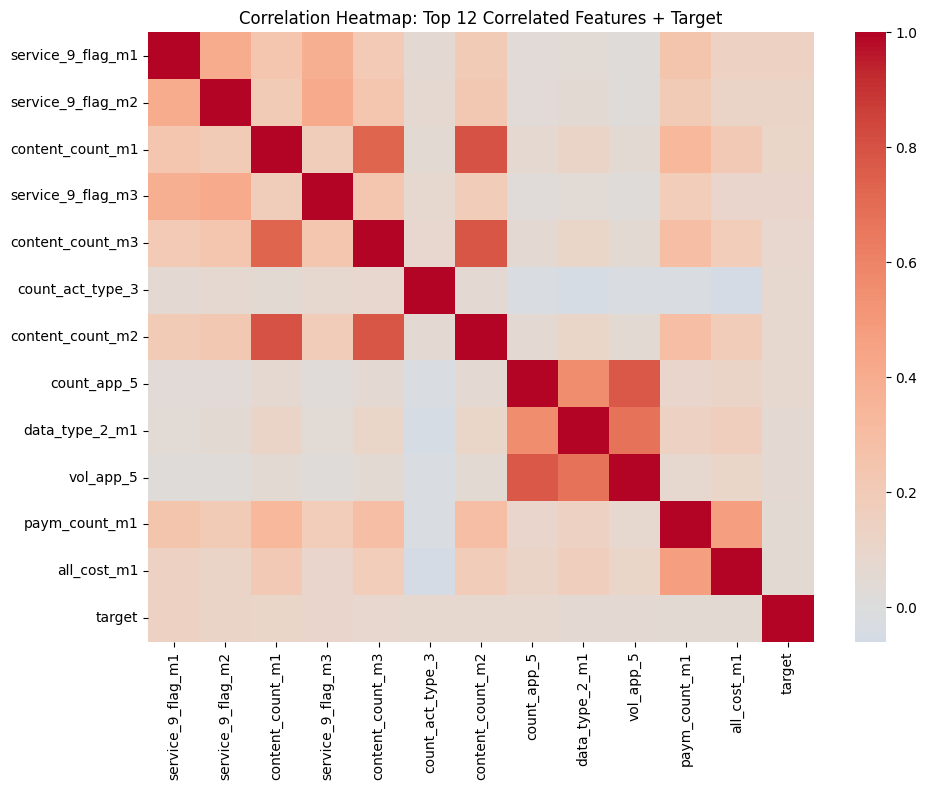

In [86]:
# 8) Correlation heatmap: check relationships among top correlated features
top_corr_features = corr_with_target.head(12).index.tolist()

plt.figure(figsize=(10, 8))
sns.heatmap(
    df_eda[top_corr_features + ["target"]].corr(numeric_only=True),
    center=0,
    cmap="coolwarm",
    annot=False
)
plt.title("Correlation Heatmap: Top 12 Correlated Features + Target")
plt.tight_layout()
plt.show()


**The analysis of feature–target relationships shows that Vodafone Music adoption is driven by behavioral engagement patterns rather than a single dominant predictor.**

*Key findings:*

- `lt` (Life Time of Client) demonstrates a clear monotonic relationship with the target: newer clients are significantly more likely to install Vodafone Music.
- Service-related flags and content usage features are positively associated with adoption.
- Users with higher digital activity (app usage, content consumption, payments) show higher installation rates.
- No feature exhibits strong standalone correlation with the target; predictive power is distributed across multiple moderately informative variables.
- Moderate multicollinearity exists among lag features (m1/m2/m3), which is expected for time-based telecom metrics.

**Overall, Vodafone Music is primarily adopted by digitally active and newer subscribers, and effective prediction will require combining multiple behavioral signals rather than relying on a single feature.**

## 6. Feature Engineering

In [54]:
X.dtypes

device_type                int64
manufacturer_category      int64
os_category                int64
sim_count                float64
tp_flag                    int64
                          ...   
income_brnd_cont_m3      float64
data_type_1_m3           float64
data_type_2_m3           float64
data_type_3_m3           float64
service_9_flag_m3        float64
Length: 379, dtype: object

In [88]:
# Check if any categorical columns exist
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Categorical columns:", categorical_cols)

Categorical columns: []


**All features in the dataset are already numeric (aggregated statistics or binary flags). No additional categorical encoding was required.**

In [90]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled shape:", X_train_scaled.shape)

Scaled shape: (56000, 379)


**StandardScaler was applied to normalize feature distributions. Scaling was performed after train-test split to prevent data leakage.**

In [91]:
mi = mutual_info_classif(X_train, y_train, random_state=42)

mi_df = (
    pd.DataFrame({"feature": X.columns, "mi": mi})
    .sort_values("mi", ascending=False)
)

# Select top 100 features
top_n = 100
selected_features = mi_df.head(top_n)["feature"].tolist()

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print("Selected features:", len(selected_features))

Selected features: 100


**Feature selection was performed using Mutual Information. The top 100 most informative features were retained for modeling. This approach reduces dimensionality while preserving predictive signals.**

### Feature Engineering – Final Summary

1. No categorical encoding was required, as all variables were already numeric.
2. StandardScaler was applied to normalize feature distributions and ensure model stability.
3. Feature selection was performed using Mutual Information to retain the most informative predictors.
4. PCA was considered but not applied.

After feature selection (top 100 features via Mutual Information),dimensionality was sufficiently reduced. 
The final feature set focuses on behavioral engagement metrics (content usage, service flags, payments, and lifetime), 
which were identified during Advanced EDA as the most predictive signals.

## 7. Baseline Models